# Lattice Dynamics 2: Quasi-Harmonic Approximation

The `thermodynamics` module is developed for both harmonic approximated (HA) and quasi-harmonic approximated (QHA) lattice dynamics. For simplicity, this part is focused only on QHA phonons. For HA, please refer to the [Lattice Dynamics 1: Harmonic Approximation](harmonic.ipynb) example book in the same catagory. For phonon band and density of states, please refer to the [phonons module](https://crystal-code-tools.github.io/CRYSTALpytools/crystalpytools.phonons.html).

## Basic thermodynamic properties

This part is divided into 3 different testing cases to illustrate the available fitting procedures.

### The 'thermo_freq()' method

The `thermo_freq()` methods implements the 'mode-by-mode' fitting of frequencies.

1. DFT internal energies are fitted as adiabatic equation of states (EOS) defined in [pymatgen.eos](https://pymatgen.org/pymatgen.analysis.html#module-pymatgen.analysis.eos) module, $E_{0}(V)$.  
2. Phonon frequencies are sorted by eigenvectors and fitted as polynomial functions of volume, $\nu(V)$.  
3. The analytical expression of Gibbs free energy is fitted at given temperature and pressure to get the equilibrium volume $\text{min}\{G(V; T,p)\}$.
4. Other thermodynamic properties, including Helmholtz free energy $F$, entropy $S$, constant volume specific heat $C_{V}$ and isothermal bulk modulus $K_{T}$ are obtained.
5. Mode-specific Grüneisen parameters are obtained by deriving the fitted $\omega(V; T,p)$.
6. The macroscopic Grüneisen parameter $\gamma(T,p)$, volumetric thermal expansion coefficient $\alpha_{V}$, constant pressure specific heat $C_{p}$, adiabatic bulk modulus $K_{S}$ are obtained following the standard Grüneisen method. See the ``thermo_gruneisen()`` method below.

**NOTE**

$K_{T}$ requires a refit of $F(V)$ based on equation of states. At least 5 pressure sampling points are required to ensure a good fitting.

$\Gamma$ point phonons of Form 1 paracetamols computed at 4 different volumes are fitted and plotted. The sequence of input files is arbitrary.

In [1]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

file_list = ['qha_paracetamolGm4.out', 'qha_paracetamolGp4.out',
             'qha_paracetamolGr0.out', 'qha_paracetamolGp8.out']
T = np.array([20, 50, 80, 150, 200, 250, 330], dtype=float)
p = np.linspace(0, 0.15, 6)

qha = Quasi_harmonic(filename='qha_FreqFit.yaml', temperature=T,
                     pressure=p).from_file(*file_list, source='crystal')
qha.thermo_freq(eos_method='birch_murnaghan', poly_order=[2, 3],
                min_method='BFGS')

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:617: UserWarning: Close overlap of phonon modes detected at qpoint 0: 11 overlaps out of 240*240 mode combinations at this point.
  close_overlap = self._combine_data(ha_list, mode_sort_tol=mode_sort_tol)


Warning messages are printed out when the fitted volume data exceeds the sampled volume data at low temperature and high pressure, indicating that fittings there might be unstable.

No warning message is printed out for 0 pressure thermodynamics. The difference is <= 5 cm$^3$/mol, which is a good agreement with experimental measurements. The increased thermal expansion around 50~150K is reproduced.

Experimental Data:

[C. C. Wilson, *Z. Kristallogr. Cryst. Mater.*, 2000, **215**, 693–701](https://www.degruyter.com/document/doi/10.1524/zkri.2000.215.11.693/html)

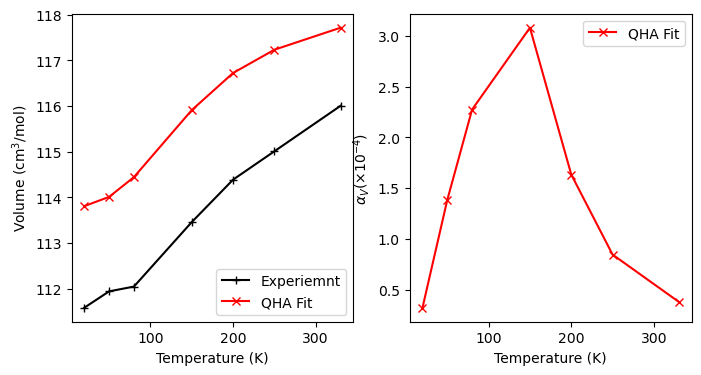

In [2]:
import matplotlib.pyplot as plt

exp = np.array([111.5836, 111.9421, 112.0463, 113.4580, 114.3871, 
                115.0082, 116.0031])
qha_zerop = qha.volume[0, :]
# Angstrom^3 to cm^3/mol
qha_zerop = qha_zerop * 0.602214 / 4

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=False)
ax[0].plot(T, exp, '+-k', label='Experiemnt')
ax[0].plot(T, qha_zerop, 'x-r', label='QHA Fit')
ax[0].legend(loc='lower right')
ax[0].set_xlabel('Temperature (K)')
ax[0].set_ylabel(r'Volume (cm$^{3}$/mol)')
ax[1].plot(T, qha.alpha_v[0, :]*1e4, 'x-r', label='QHA Fit')
ax[1].set_xlabel('Temperature (K)')
ax[1].set_ylabel(r'$\alpha_{V} (\times 10^{-4})$')
ax[1].legend(loc='upper right')

### The 'thermo_eos()' method

This test is to illustrate the procedure to fit a series of adiabatic EOSs at constant temperature to avoid eigenvectors and mode-specific fittings, which might be useful for large systems with low symmetry. But its stability is worse than ``thermo_eos()`` and ``thermo_gruneisen()``.

1. Harmonic Helmholtz free energy for each sampled volume is used to fit EOS, $F(V; T)$. 
2. The difference between analytical pressure $p(V)=-\left(\frac{\partial F}{\partial V}\right)_{T}$ and the given pressure $p_{0}$ is minimized to get the equilibrium volume, $\text{min}\left[p(V) - p_{0}\right]^{2}$.
3. Other thermodynamic properties, including Gibbs free energy $G$, constant pressure specific heat $C_{p}$ (second derivative of $F$) and isothermal bulk modulus $K_{T}$ are obtained.
4.  $G(T; p)$ is fitted as polynomial function to get entropy, $S=-\left(\frac{\partial G}{\partial T}\right)_p$.

Since the analytical $G(V)$ is not available, thermal expansion and other properties are fitted separately, see the following sections.

**NOTE**

At least 5 temperature sampling points are required to ensure a good fitting of $G(T; p)$.

The time consumption and 0 pressure thermal expansion of the `thermo_freq()` and the `thermo_eos()` methods are compared.

In [1]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic
import time

file_list = ['qha_paracetamolGm4.out', 'qha_paracetamolGp4.out',
             'qha_paracetamolGr0.out', 'qha_paracetamolGp8.out']
tempt = np.array([0, 20, 50, 80, 150, 200, 250, 330], dtype=float)
press = np.linspace(0, 0.15, 6)

mode = Quasi_harmonic(filename='qha_FreqFit.yaml').from_file(*file_list, source='crystal', mode_sort_tol=0.4)
eos = Quasi_harmonic(filename='qha_EoSFit.yaml').from_file(*file_list, source='crystal', mode_sort_tol=None)

tbg = time.perf_counter()
# Mode-specific
mode.thermo_freq(temperature=tempt, pressure=press,
                 eos_method='birch_murnaghan',
                 poly_order=3, min_method='BFGS', mutewarning=True)

tmode = time.perf_counter()
# EoS
eos.thermo_eos(temperature=tempt, pressure=press,
               eos_method='birch_murnaghan',
               poly_order=3, mutewarning=True)

teos = time.perf_counter()
print('Time consumption for Mode-Specific fitting: %12.6f s' % (tmode - tbg))
print('Time consumption for EoS fitting: %12.6f s' % (teos - tmode))

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:617: UserWarning: Close overlap of phonon modes detected at qpoint 0: 11 overlaps out of 240*240 mode combinations at this point.
  close_overlap = self._combine_data(ha_list, mode_sort_tol=mode_sort_tol)


Time consumption for Mode-Specific fitting:     1.437133 s
Time consumption for EoS fitting:     0.592790 s


0 pressure thermal expansion.

Text(0, 0.5, 'Volume (cm$^{3}$/mol)')

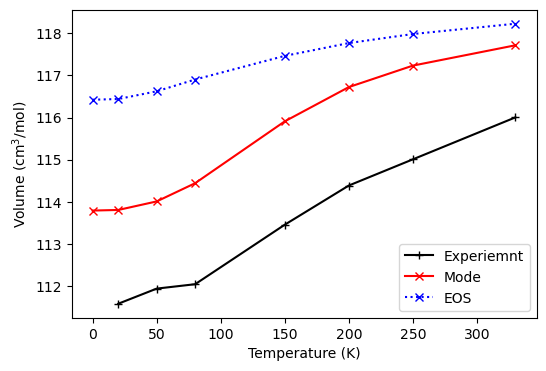

In [2]:
import matplotlib.pyplot as plt

exp = np.array([111.5836, 111.9421, 112.0463, 113.4580, 114.3871,
                115.0082, 116.0031])
# Angstrom^3 to cm^3/mol
vol_mode = mode.volume[0, :] * 0.602214 / 4
vol_eos = eos.volume[0, :] * 0.602214 / 4

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(tempt[1:], exp, '+-k', label='Experiemnt')
ax.plot(tempt, vol_mode, 'x-r', label='Mode')
ax.plot(tempt, vol_eos, 'x:b', label='EOS')

ax.legend(loc='lower right')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Volume (cm$^{3}$/mol)')

It should be noted that entropy $S(V, T)$ is obtained by $S=-\left(\frac{\partial G}{\partial T}\right)_{p}$, where $G(T; p)$ is a polynomial fitting. That makes it less accurate compared to mode-specific fittings. See below.

In [3]:
print('{:>3s}{:>10s}{:>10s}{:>16s}{:>16s}'.format('T', 'S(mode)', 'S(EOS)', 'F(mode) 10^6', 'F(EOS) 10^6'))
for i in range(len(mode.temperature)):
    print('{:3.0f}{:10.2f}{:10.2f}{:16.8f}{:16.8f}'.format(
            mode.temperature[i], mode.entropy[0,i], eos.entropy[0,i],
            mode.helmholtz[0,i]/1e6, eos.helmholtz[0,i]/1e6
    ))

  T   S(mode)    S(EOS)    F(mode) 10^6     F(EOS) 10^6
  0      0.00     -0.00     -5.40069739     -5.40069872
 20      9.48     46.65     -5.40069744     -5.40069878
 50     84.41    117.80     -5.40069893     -5.40070031
 80    177.61    190.37     -5.40070329     -5.40070465
150    378.34    365.20     -5.40072438     -5.40072461
200    506.24    494.80     -5.40074729     -5.40074769
250    626.09    628.34     -5.40077605     -5.40077622
330    808.84    850.18     -5.40083387     -5.40083385


### The 'thermo_gruneisen()' method

This method uses the standard Grüneisen model with following steps:

1. The pressure and temperature independent mode-specific Grüneisen parameters are fitted based on the volume $V_{0}$ and freqency $\omega_{0}$ of the most compact structure:

$$\gamma_{\textbf{q}i}=-\frac{\ln{\omega}-\ln{\omega_{0}}}{\ln{V}-\ln{V_{0}}}$$

2. Frequency at given volume can be expressed analytically by:

$$\omega_{\textbf{q}i}(V) = \omega_{\textbf{q}i}(V_{0})\left(\frac{V}{V_{0}}\right)^{-\gamma_{\textbf{q}i}}$$

3. Then $G(V; T,p)$ is expressed and minimized in the same way as ``thermo_freq()``. The equilibrium volume, Helmholtz free energy $F$, entropy $S$, constant volume specific heat $C_{V}$ and isothermal bulk modulus $K_{T}$ are obtained.

4. The macroscopic Grüneisen parameter $\gamma$ is defined as $\sum_{\textbf{q}i}\frac{\gamma_{\textbf{q}i}C_{V,\textbf{q}i}}{C_{V}}$

5. With $\gamma$, we obtain volumetric themal expansion $\alpha_{V} = \frac{\gamma C_{V}}{K_{T}V}$

6. With $\alpha_{V}$, we obtain adiabatic bulk moduli $K_{S} = K_{T} + \frac{\alpha^{2}_{V}VTK^{2}_{T}}{C_{V}}$ and constant pressure specific heat $C_{p} = C_{V} + \alpha^{2}_{V}K_{T}VT$.

Read QHA output of Al$_{2}$O$_{3}$ and fit with `thermo_gruneisen` and fit equilibrium volumes.

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:617: UserWarning: Close overlap of phonon modes detected at qpoint 0: 40 overlaps out of 90*90 mode combinations at this point.
  close_overlap = self._combine_data(ha_list, mode_sort_tol=mode_sort_tol)


Text(0, 0.5, 'Volume ($\\AA^{3}$)')

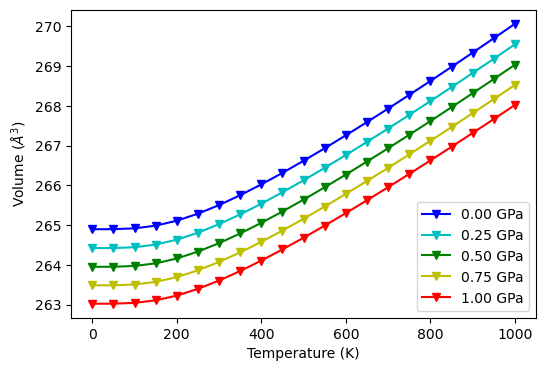

In [4]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic
import matplotlib.pyplot as plt

file = 'qha_corundumG.out'
T = np.linspace(0, 1000, 21)
p = np.linspace(0, 1, 5)

gru = Quasi_harmonic(filename='qha_GruFit.yaml').from_file(file, source='crystal-QHA')
gru.thermo_gruneisen(temperature=T, pressure=p, eos_method='birch_murnaghan',
                     poly_order=3, min_method='BFGS')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
style = ['v-b', 'v-c', 'v-g', 'v-y', 'v-r']

for v, s, p in zip(gru.volume, style, gru.pressure):
    ax.plot(T, v, s, label='{:.2f} GPa'.format(p))

ax.legend(loc='lower right')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Volume ($\AA^{3}$)')

Other thermodynamic properties by Grüneisen model.

In [5]:
print('Macroscopic Grüneisen parameter at 1000K, 0GPa : {:.4f}'.format(gru.gruneisen[0, -1]))
print('Thermal expansion coefficient at 500K, 1GPa : {:.8f}'.format(gru.alpha_v[-1, 10]))
print('Constant pressure specific heat at 500K, 1GPa : {:.4f} J/mol/K'.format(gru.c_p[-1, 10]))
print('Adiabatic bulk modulus at 500K, 1GPa : {:.4f} GPa'.format(gru.k_s[-1, 10]))

Macroscopic Grüneisen parameter at 1000K, 0GPa : 1.3730
Thermal expansion coefficient at 500K, 1GPa : 0.00002219
Constant pressure specific heat at 500K, 1GPa : 617.5379 J/mol/K
Adiabatic bulk modulus at 500K, 1GPa : 240.1427 GPa


## Restart QHA calculations

With the dumped YAML file, the user can extract the sorted and fitted phonons when restarting a calculation. Fittings are dumped by `thermo_*` methods, and can be read to calculate other themodynamic propertes.

In [6]:
from CRYSTALpytools.thermodynamics import Quasi_harmonic

freq = Quasi_harmonic.restart('qha_FreqFit.yaml')
print("QHA method: {}".format(freq.method))
print("EOS method: {}".format(freq.eos_method))
print("Frequency polynomial order:")
print(freq.fit_order)

gru = Quasi_harmonic.restart('qha_GruFit.yaml')
print("QHA method: {}".format(gru.method))
print("EOS method: {}".format(gru.eos_method))
print("Gruneisen parameter of mode 4 at Gamma:")
print(gru.gru_fit[0, 3])

eos = Quasi_harmonic.restart('qha_EoSFit.yaml')
print("QHA method: {}".format(eos.method))
print("EOS method: {}".format(eos.eos_method))
print("Gibbs free energy polynomial order:")
print(eos.fit_order)

QHA method: thermo_freq
EOS method: birch_murnaghan
Frequency polynomial order:
[3]
QHA method: thermo_gruneisen
EOS method: birch_murnaghan
Gruneisen parameter of mode 4 at Gamma:
1.655541049447
QHA method: thermo_eos
EOS method: birch_murnaghan
Gibbs free energy polynomial order:
[3]


## Other thermodynamic properties

After getting the basic properties (equilibirum volum, entropy, Helmholtz free energy and Gibbs free energy) with methods in the previous section, other properties can be obtained with methods in this section. For simplicity properties calculated here are read from dumped restart files.

### The 'expansion_vol()' method

The `Quasiharmonic.expansion_vol()` method fits the volumetric thermal expansion coefficients at constant pressure, $\alpha_{V}(T; p)$. For QHA objects generated by `thermo_freq()` or `thermo_gruneisen()` methods, thermal expansions have been fitted with the Grüneisen model. Calling this will overwrites the fitted data.

With `plot` option, the user can inspect the quality of fittings from the output figure. If `plot=False`, the code will fit $V(T; p)$ with polynomials that maximizes $R^{2}$ of each curve. ``poly_order`` must >= 2.

/tmp/ipykernel_19447/2306850625.py:5: UserWarning: The fitted thermal expansion coefficient will be overwritten.
  obj.expansion_vol(poly_order=[2, 3, 4], plot=True, fit_fig='qha_paracetamolG.png')


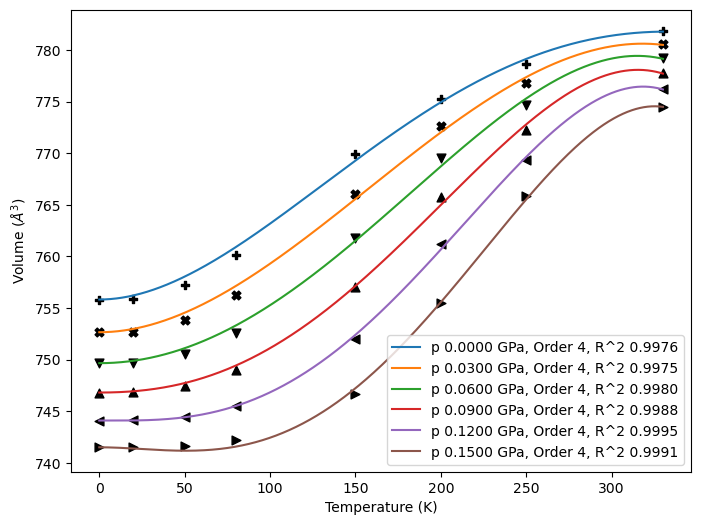

In [7]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

obj = Quasi_harmonic.restart('qha_FreqFit.yaml')
obj.expansion_vol(poly_order=[2, 3, 4], plot=True, fit_fig='qha_paracetamolG.png')

Plot $\alpha_{V}$.

Text(0, 0.5, '$\\alpha_{V}$ (10$^{-5}$)')

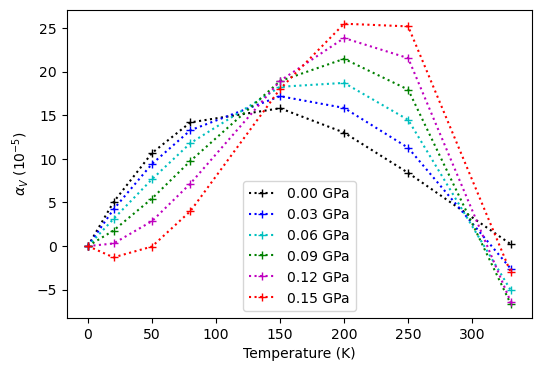

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
style = ['+:k', '+:b', '+:c', '+:g', '+:m', '+:r']
for alpha, stl, p in zip(obj.alpha_v, style, obj.pressure):
    ax.plot(obj.temperature, alpha*1e5, stl, label='{:.2f} GPa'.format(p))

ax.legend(loc='lower center')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\alpha_{V}$ (10$^{-5}$)')

### The 'specific_heat()' method

The `Quasiharmonic.specific_heat()` method computes constant volume $C_{V}$ or pressure $C_{p}$ specific heat.

* For `thermo_freq` and `thermo_gruneisen`, `self.c_p` have been fitted with the Grüneisen model. Calling this will overwrites the fitted data.  
* For `thermo_eos`, this method fits `self.c_v` from `self.c_p`. The `expansion_vol()` method must be called first.

In [9]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

obj = Quasi_harmonic.restart('qha_EoSFit.yaml')
obj.expansion_vol(poly_order=3, plot=False)
obj.specific_heat()

print('C_V at 250K, 0GPa = {:.4f} J/mol/K'.format(obj.c_v[0, 6]))
print('C_p at 250K, 0GPa = {:.4f} J/mol/K'.format(obj.c_p[0, 6]))

C_V at 250K, 0GPa = 671.4640 J/mol/K
C_p at 250K, 0GPa = 677.5143 J/mol/K


### The 'bulk_modulus' method

The `Quasiharmonic.bulk_modulus()` method computes the adiabatic $K_{S}$ bulk moduli.

* For `thermo_freq` and `thermo_gruneisen`, `self.k_s` have been fitted with the Grüneisen model. Calling this will overwrites the fitted data.  
* For `thermo_eos`, this method fits `self.k_s` from `self.k_t`. The `expansion_vol()` method must be called first.

In [10]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

obj = Quasi_harmonic.restart('qha_GruFit.yaml')
obj.bulk_modulus()

print('K_T at 300K, 0GPa = {:.4f} GPa'.format(obj.k_t[0, 6]))
print('K_S at 300K, 0GPa = {:.4f} GPa'.format(obj.k_s[0, 6]))

K_T at 300K, 0GPa = 233.5873 GPa
K_S at 300K, 0GPa = 235.2532 GPa


/tmp/ipykernel_19447/3728630731.py:5: UserWarning: Attributes 'k_s' exists, the fitting will be overwritten.
  obj.bulk_modulus()


## Anisotropic lattice expansions

Fits anisotropic lattice expansions, i.e., lattice parameters, from sampled HA calculation and fitted volumes. In practice, lattice matrices are fitted. To minimize the orders of freedom, the structure will be expanded and aligned to the standard representations of conventional cells when fitting. If there is no expansion, the structure will be reoriented to input geometry for consistency.

### The 'lattice_poly()' method

It fits linear expansions of the minimal set of lattice parameters. Volume constrain is applied to reduce one inequivalent lattice parameter.

**NOTE**

Equilibrium volumes must be fit with `thermo_*()` methods first.

The `lattice_poly()` method individually fits lattice parameter $a$ as the polynomial function of volume $V$ at contant pressures. The optimized lattice parameters at DFT level are used for fitting.

Fit and plot lattice parameters of paracetamol. The fitted lattice matrices is saved in `self.lattice` attribute. The inequivalent lattice parameters are saved in `self.latt_params` attribute.

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:617: UserWarning: Close overlap of phonon modes detected at qpoint 0: 11 overlaps out of 240*240 mode combinations at this point.
  close_overlap = self._combine_data(ha_list, mode_sort_tol=mode_sort_tol)


Text(0, 0.5, 'Degree ($\\circ$)')

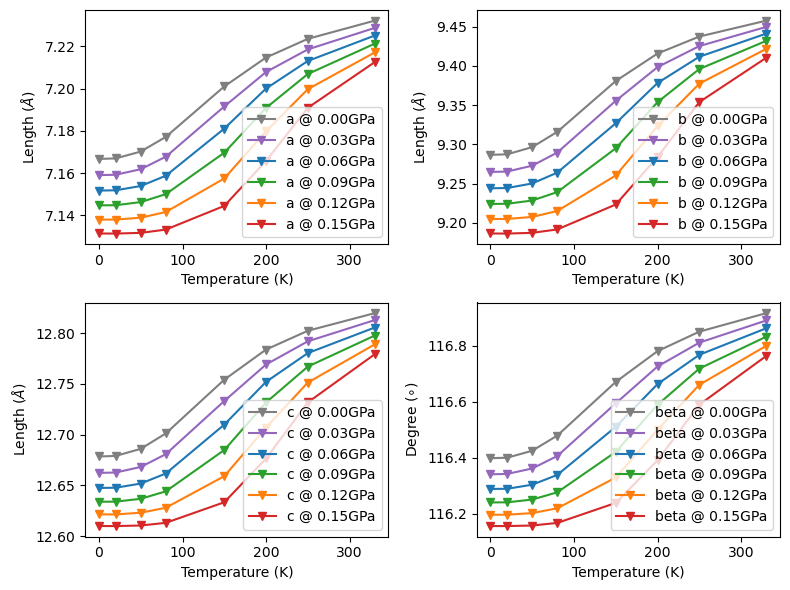

In [11]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic
import matplotlib.pyplot as plt


file_list = ['qha_paracetamolGm4.out', 'qha_paracetamolGp4.out',
             'qha_paracetamolGr0.out', 'qha_paracetamolGp8.out']
T = np.array([0, 20, 50, 80, 150, 200, 250, 330], dtype=float)
p = np.linspace(0, 0.15, 6)

obj = Quasi_harmonic(filename='qha_LattPolyFit.yaml', temperature=T,
                     pressure=p).from_file(*file_list, source='crystal')
obj.thermo_freq(eos_method='birch_murnaghan', poly_order=[2, 3],
                min_method='BFGS')
obj.lattice_poly(poly_order=3)

fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey=False, layout='tight')

name = ['a', 'b', 'c', 'beta']
color = ['tab:gray', 'tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:red']
for il in range(obj.latt_params.shape[-1]):
    for ip in range(obj.latt_params.shape[0]):
        # nPressure*nTemperature*nLattice
        fig.axes[il].plot(T, obj.latt_params[ip, :, il], color=color[ip],
                          marker='v', label='{} @ {:.2f}GPa'.format(name[il], p[ip]))
    fig.axes[il].legend(loc='lower right')
    fig.axes[il].set_xlabel('Temperature (K)')
    fig.axes[il].set_ylabel(r'Length ($\AA$)')
fig.axes[-1].set_ylabel(r'Degree ($\circ$)')

### The 'lattice_hess()' method

It adopts a multi-dimensional 2-order perturbation around the minimal set of equilibrium lattice parameters.

$$G(\mathbf{v}) = G_{0}(\mathbf{v}_{0}) + \Delta\mathbf{v}\mathbf{H}\Delta\mathbf{v}^{T}$$

$\Delta\mathbf{v}$ is the difference between the lattice parameters of sampled HA calculations and the equilibrium ones (to be fitted). The root-mean-squared deviations (RMSD) between $\Delta\mathbf{v}\mathbf{H}\Delta\mathbf{v}^{T}$ and $G-G_{0}$ is minimized at constant temperature and pressure.

This method requires a larger number of HA calculations to ensure a robust fitting, which depends on the symmetry of the system. Volume constrain is applied, but its dimension in $\mathbf{H}$ is kept.

Minimum HA references:

* Hexagonal, trigonal and tetragonal: 4  
* Orthorhombic: 8  
* Monoclinic: 13  
* Triclinic: 26

Use ``interp`` to linearly interpolate reference geometries and insert reference Gibbs free energies. Only available  to objects generated by ``thermo_freq()`` and ``thermo_gruneisen()``. ``interp`` must less than ``self.ncalc``.

**NOTE**

Recommended for finite temperatures and pressures.

Fit and plot lattice parameters of corundum.

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:617: UserWarning: Close overlap of phonon modes detected at qpoint 0: 40 overlaps out of 90*90 mode combinations at this point.
  close_overlap = self._combine_data(ha_list, mode_sort_tol=mode_sort_tol)


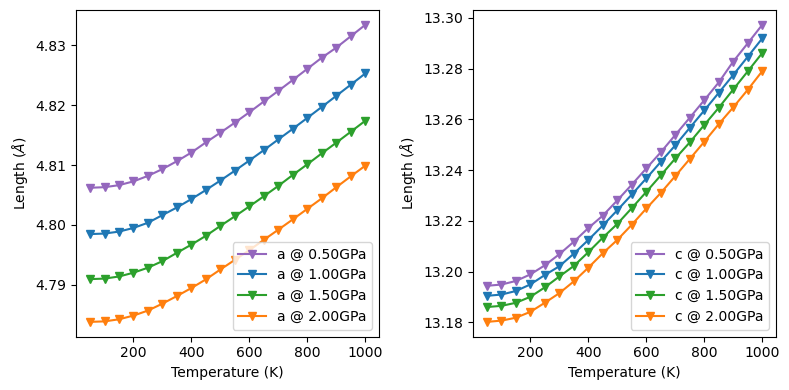

In [12]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic
import matplotlib.pyplot as plt

T = np.linspace(50, 1000, 20)
p = np.linspace(0.5, 2, 4)

obj = Quasi_harmonic(filename='qha_LattHessFit.yaml', temperature=T, pressure=p)
obj.from_file('qha_corundumG.out', source='crystal-QHA')
obj.thermo_gruneisen()
obj.lattice_hess(interp=1)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=False, layout='tight')

name = ['a', 'c']
color = ['tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:red']
for il in range(obj.latt_params.shape[-1]):
    for ip in range(obj.latt_params.shape[0]):
        # nPressure*nTemperature*nLattice
        ax[il].plot(T, obj.latt_params[ip, :, il], color=color[ip],
                    marker='v', label='{} @ {:.2f}GPa'.format(name[il], p[ip]))
    ax[il].legend(loc='lower right')
    ax[il].set_xlabel('Temperature (K)')
    ax[il].set_ylabel(r'Length ($\AA$)')

### The 'expansion_latt()' method

It fits the linear expansion coefficients of the minimal set of lattice parameters. The quality of fittings can be evaluated by `plot=True`.

**NOTE**

Equilibrium lattice parameters must be fit with `lattice_*()` methods first.

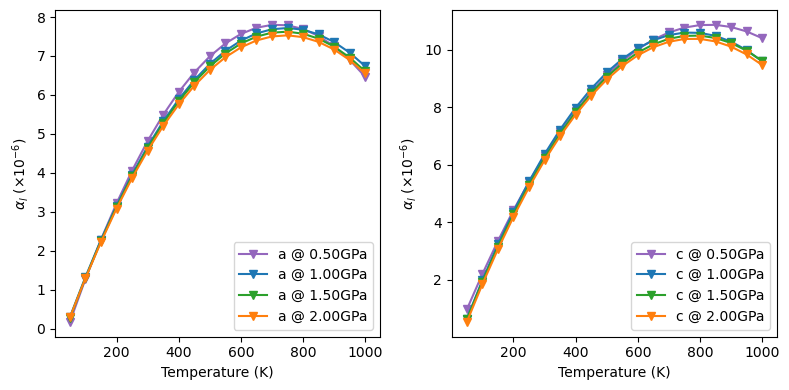

In [13]:
from CRYSTALpytools.thermodynamics import Quasi_harmonic
import matplotlib.pyplot as plt

obj = Quasi_harmonic.restart('qha_LattHessFit.yaml')
obj.expansion_latt(plot=False)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=False, layout='tight')

name = ['a', 'c']
color = ['tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:red']
for il in range(obj.alpha_l.shape[-1]):
    for ip in range(obj.alpha_l.shape[0]):
        # nPressure*nTemperature*nLattice
        ax[il].plot(obj.temperature, obj.alpha_l[ip, :, il]*1e6, color=color[ip],
                    marker='v', label='{} @ {:.2f}GPa'.format(name[il], obj.pressure[ip]))
    ax[il].legend(loc='lower right')
    ax[il].set_xlabel('Temperature (K)')
    ax[il].set_ylabel(r'$\alpha_{l}$ $(\times10^{-6})$')

For monoclinic and triclinic systems, use `Cartesian=True` for expansion rates along Cartesian coordinates.

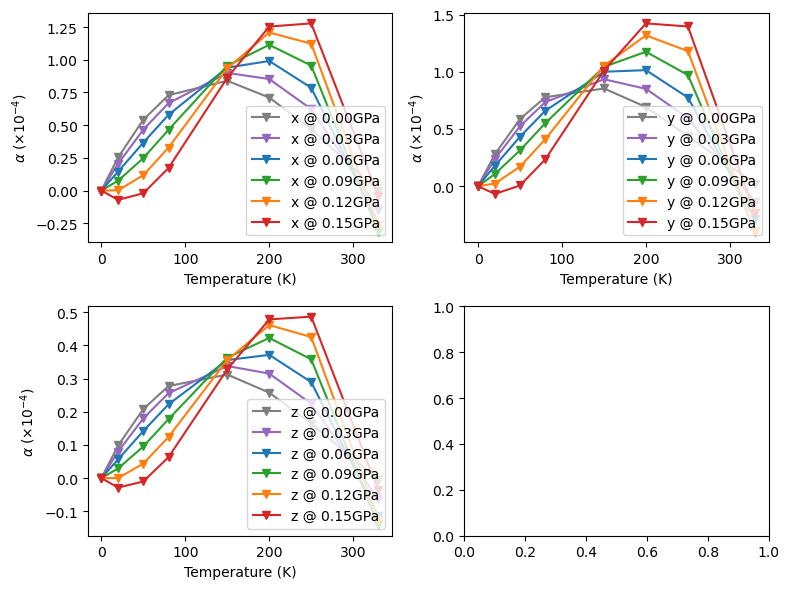

In [14]:
from CRYSTALpytools.thermodynamics import Quasi_harmonic
import matplotlib.pyplot as plt

obj = Quasi_harmonic.restart('qha_LattPolyFit.yaml')
obj.expansion_latt(poly_order=4, plot=False, Cartesian=True)

fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey=False, layout='tight')

name = ['x', 'y', 'z']
color = ['tab:gray', 'tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:red']
for il in range(obj.alpha_l.shape[-1]):
    for ip in range(obj.alpha_l.shape[0]):
        # nPressure*nTemperature*nLattice
        fig.axes[il].plot(obj.temperature, obj.alpha_l[ip, :, il]*1e4, color=color[ip],
                          marker='v', label='{} @ {:.2f}GPa'.format(name[il], obj.pressure[ip]))
    fig.axes[il].legend(loc='lower right')
    fig.axes[il].set_xlabel('Temperature (K)')
    fig.axes[il].set_ylabel(r'$\alpha$ $(\times10^{-4})$')

For more information please refer to the [API documentation](https://crystal-code-tools.github.io/CRYSTALpytools/crystalpytools.thermodynamics.html).